# Loading Dataset From Kaggle

In [ ]:
!pip install kaggle --quiet

In [ ]:
#upload kaggle json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle (2).json': b'{"username":"kavinprasanthr75","key":"71464159f5d84b82e816e0c12f330c13"}'}

In [ ]:
# kaggle directory
!mkdir -p ~/.kaggle

In [ ]:
#copy kaggle.json file
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
ls -ltr ~/.kaggle

total 4
-rw------- 1 root root 72 Oct 26 11:19 kaggle.json


In [ ]:
!kaggle competitions download -c bosch-production-line-performance -p datasets

100% 678M/680M [00:10<00:00, 71.4MB/s]
100% 680M/680M [00:10<00:00, 65.4MB/s]


In [ ]:
import zipfile
from pathlib import Path
import os

data_dir = Path("datasets")

# Iterate through all files in the datasets directory
for file in os.listdir(data_dir):
    if file.endswith(".zip"):
        file_path = data_dir / file
        try:
            with zipfile.ZipFile(file_path, "r") as z:
                z.extractall(data_dir)
            print(f" Files extracted from: {file}")
            # Remove the zip file after extraction
            os.remove(file_path)
            print(f" Removed zip file: {file}")
        except zipfile.BadZipFile:
            print(f"Error: Could not open zip file {file_path}. It might be corrupted or not a valid zip file.")


print("All zip files processed in:", data_dir)

# =============================
# STEP 5: Verify Contents
# =============================
!ls datasets

 Files extracted from: bosch-production-line-performance.zip
 Removed zip file: bosch-production-line-performance.zip
All zip files processed in: datasets
sample_submission.csv	   test_date.csv.zip	      train_date.csv
sample_submission.csv.zip  test_numeric.csv	      train_date.csv.zip
test_categorical.csv	   test_numeric.csv.zip       train_numeric.csv
test_categorical.csv.zip   train_categorical.csv      train_numeric.csv.zip
test_date.csv		   train_categorical.csv.zip


In [ ]:
import zipfile
from pathlib import Path
import os

data_dir = Path("datasets")

# Iterate through all files in the datasets directory
for file in os.listdir(data_dir):
    if file.endswith(".zip"):
        file_path = data_dir / file
        try:
            with zipfile.ZipFile(file_path, "r") as z:
                z.extractall(data_dir)
            print(f" Files extracted from: {file}")
            # Remove the zip file after extraction
            os.remove(file_path)
            print(f" Removed zip file: {file}")
        except zipfile.BadZipFile:
            print(f"Error: Could not open zip file {file_path}. It might be corrupted or not a valid zip file.")


print("All zip files processed in:", data_dir)

# =============================
# STEP 5: Verify Contents
# =============================
!ls datasets

 Files extracted from: train_categorical.csv.zip
 Removed zip file: train_categorical.csv.zip
 Files extracted from: test_date.csv.zip
 Removed zip file: test_date.csv.zip
 Files extracted from: train_numeric.csv.zip
 Removed zip file: train_numeric.csv.zip
 Files extracted from: sample_submission.csv.zip
 Removed zip file: sample_submission.csv.zip
 Files extracted from: test_categorical.csv.zip
 Removed zip file: test_categorical.csv.zip
 Files extracted from: train_date.csv.zip
 Removed zip file: train_date.csv.zip
 Files extracted from: test_numeric.csv.zip
 Removed zip file: test_numeric.csv.zip
All zip files processed in: datasets
sample_submission.csv  test_numeric.csv       train_numeric.csv
test_categorical.csv   train_categorical.csv
test_date.csv	       train_date.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import gc
import sys
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load data
numeric_df = pd.read_csv("/content/datasets/train_numeric.csv", nrows = 10000)
categorical_df = pd.read_csv("/content/datasets/train_categorical.csv", nrows = 10000)
date_df = pd.read_csv("/content/datasets/train_date.csv", nrows = 10000)

# Step 1: Drop columns with >99% missing values in numeric data
missing_threshold = 0.99
cols_to_drop = numeric_df.columns[numeric_df.isnull().mean() > missing_threshold]
numeric_df.drop(columns=cols_to_drop, inplace=True)

# Step 2: Encode categorical columns to numeric
for col in categorical_df.columns:
    if col != 'Id':
        le = LabelEncoder()
        categorical_df[col] = le.fit_transform(categorical_df[col].astype(str))

# Step 3: Merge datasets on 'Id'
data = numeric_df.merge(categorical_df, on='Id')
data = data.merge(date_df, on='Id')

# Step 4: Feature engineering on date_df
# Convert date columns to datetime
for col in date_df.columns:
    if col != 'Id':
        date_df[col] = pd.to_datetime(date_df[col])

# Calculate elapsed time (max - min) per sample
min_times = date_df.loc[:, date_df.columns != 'Id'].min(axis=1)
max_times = date_df.loc[:, date_df.columns != 'Id'].max(axis=1)
elapsed_time = (max_times - min_times).dt.total_seconds()

# Create DataFrame for time features and merge
time_features = pd.DataFrame({'Id': date_df['Id'], 'elapsed_time_sec': elapsed_time})
data = data.merge(time_features, on='Id', how='left')

# Step 5: Add missing value count feature
data['missing_count'] = data.isnull().sum(axis=1)


# Step 7: Optimize data types
for col in data.select_dtypes(include=['float']).columns:
    data[col] = pd.to_numeric(data[col], downcast='float')
for col in data.select_dtypes(include=['int']).columns:
    data[col] = pd.to_numeric(data[col], downcast='integer')

print(f'Data shape after processing: {data.shape}')
print(data[['elapsed_time_sec', 'missing_count']].head())


Data shape after processing: (10000, 4014)
   elapsed_time_sec  missing_count
0      5.000000e-09           1529
1      2.000000e-09           1469
2      6.000000e-09           1473
3      5.000000e-09           1473
4      4.000000e-09           1473


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Prepare features and target as before
features = [col for col in data.columns if col not in ['Id', 'Response']]
X = data[features]
y = data['Response']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 64,
    "learning_rate": 0.05,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "is_unbalance": True,  # Alternatively use scale_pos_weight
    #"device": "gpu",
    #"gpu_platform_id": 0,
    #"gpu_device_id": 0,
    "max_bin": 255
}

callbacks = [
    lgb.early_stopping(stopping_rounds=50),
    lgb.log_evaluation(period=50)
]

print("\nTraining LightGBM model...")

model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=500,
    callbacks=callbacks
)

# Evaluate
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
auc = roc_auc_score(y_val, y_pred)
print(f'Validation AUC: {auc:.5f}')



Training LightGBM model...
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.99972	valid_1's auc: 0.61735
Early stopping, best iteration is:
[3]	training's auc: 0.909142	valid_1's auc: 0.700603
Validation AUC: 0.70060


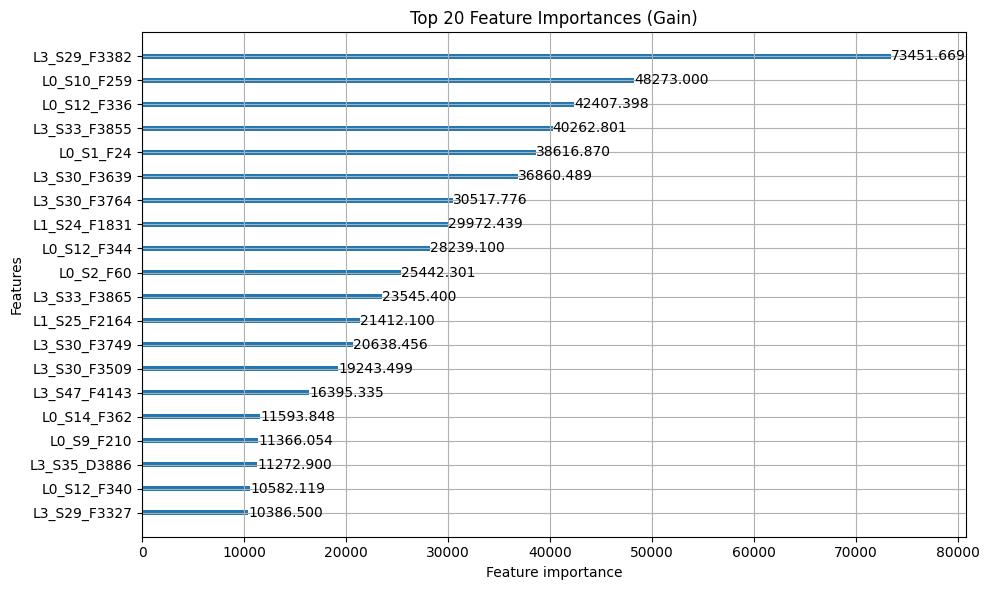

           feature  importance_gain  importance_split
490   L3_S29_F3382     73451.668803                 2
65     L0_S10_F259     48273.000000                 1
84     L0_S12_F336     42407.398438                 1
595   L3_S33_F3855     40262.800781                 1
12       L0_S1_F24     38616.870362                 2
551   L3_S30_F3639     36860.488900                 3
576   L3_S30_F3764     30517.776114                 4
348   L1_S24_F1831     29972.439453                 2
88     L0_S12_F344     28239.099609                 1
21       L0_S2_F60     25442.300781                 1
600   L3_S33_F3865     23545.400391                 1
421   L1_S25_F2164     21412.099609                 1
573   L3_S30_F3749     20638.456005                 6
525   L3_S30_F3509     19243.498787                 2
680   L3_S47_F4143     16395.334684                 3
96     L0_S14_F362     11593.847691                 2
56      L0_S9_F210     11366.054001                 2
3888  L3_S35_D3886     11272

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

# Plot feature importance (gain is most useful metric)
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.title("Top 20 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

# If you want a DataFrame for further analysis or custom plotting
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance_gain': model.feature_importance(importance_type='gain'),
    'importance_split': model.feature_importance(importance_type='split')
})

# Show top 20 features by gain
print(importance_df.sort_values(by='importance_gain', ascending=False).head(20))


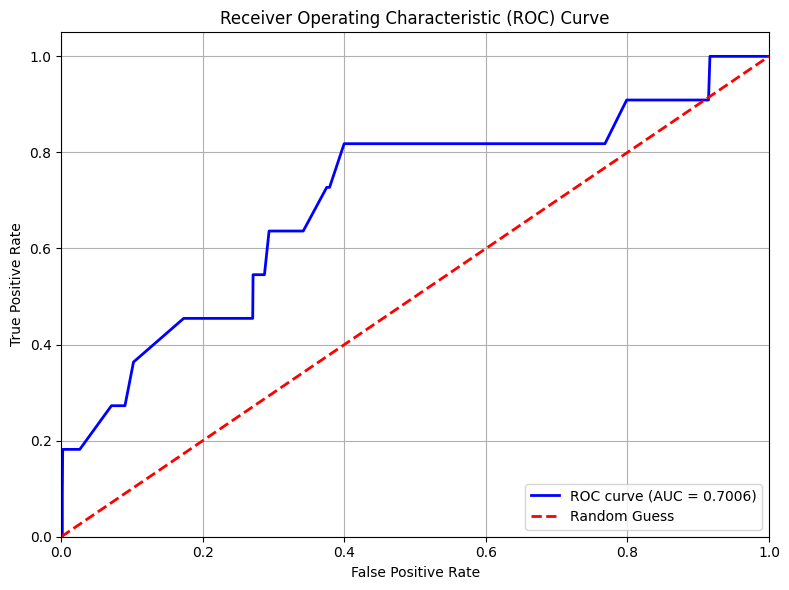

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_val: true labels, y_pred: predicted probabilities from model.predict
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import matthews_corrcoef, confusion_matrix, RocCurveDisplay
import xgboost as xgb




In [ ]:
# Merge on Id column
data = numeric.merge(date, how='left', on='Id').merge(cat, how='left', on='Id')

# Separate target and drop 'Id' and 'Response' from features
target = data['Response']
data.drop(['Response', 'Id'], axis=1, inplace=True)

# Fill missing categorical values with 'not_passed'
cat_cols = cat.columns.drop('Id')
data[cat_cols] = data[cat_cols].fillna('not_passed')

# Encode categorical data
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
data[cat_cols] = encoder.fit_transform(data[cat_cols])

# Fill missing numeric and date features with 0
num_date_cols = numeric.columns.drop(['Id', 'Response']).tolist() + date.columns.drop('Id').tolist()
data[num_date_cols] = data[num_date_cols].fillna(0)

# Normalize numeric and date features
scaler = MinMaxScaler()
data[num_date_cols] = scaler.fit_transform(data[num_date_cols])


NameError: name 'numeric' is not defined

In [ ]:
# Number of categories passed in categorical features
data['num_categories'] = (data[cat_cols] != -1).sum(axis=1)

# Number of distinct categories in each product record
data['num_diff_categories'] = data[cat_cols].nunique(axis=1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

# ------------------------------------------------------------
# 1️⃣ Split data
# ------------------------------------------------------------
X = data.drop(columns=['Response'], errors='ignore')
y = target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:", np.bincount(y_train))

# ------------------------------------------------------------
# 2️⃣ Apply SMOTE for class balancing
# ------------------------------------------------------------
sm = SMOTE(random_state=42, sampling_strategy=0.2)
# ↑ 0.2 means minority class will be 20% of majority; you can try 0.5 or 1.0
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_res))

# ------------------------------------------------------------
# 3️⃣ Train XGBoost model
# ------------------------------------------------------------
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'max_depth': 7,
    'min_child_weight': 3,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'subsample': 0.8,
    'gamma': 0,
    'lambda': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'seed': 2025
}

evals = [(dtrain, 'train'), (dval, 'eval')]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=50
)

# ------------------------------------------------------------
# 4️⃣ Predict with best iteration
# ------------------------------------------------------------
y_pred_prob = bst.predict(dval, iteration_range=(0, bst.best_iteration + 1))

# Tune threshold for best F1
prec, rec, thresh = precision_recall_curve(y_val, y_pred_prob)
f1_scores = 2*prec*rec / (prec+rec)
best_thresh = thresh[np.argmax(f1_scores)]
print(f"\nOptimal threshold: {best_thresh:.3f}")

y_pred = (y_pred_prob > best_thresh).astype(int)

# ------------------------------------------------------------
# 5️⃣ Evaluate performance
# ------------------------------------------------------------
print("\n📊 Evaluation Metrics (with SMOTE):")
print(f"Accuracy:  {accuracy_score(y_val, y_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_pred):.4f}")
print(f"Recall:    {recall_score(y_val, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_val, y_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_val, y_pred_prob):.4f}")

# ------------------------------------------------------------
# 6️⃣ Plot Precision–Recall Curve
# ------------------------------------------------------------
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SMOTE)")
plt.show()
